Team Members (all 5000):

Max Link

Alex Chen

Pablo Arroliga


Preparation
[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.

Dataset:
Our dataset is the "Coronavirus tweets NLP - text" dataset from Kaggle: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/code



The dataset contains 4 columns of data:
1) Location 2) Tweet At 3) Original Tweet 4) Label

We are only interested in 3 and 4. The orignal tweet is the text of tweet relating to coronavirus (COVID), and the label is a 5-level categorical variable representing the sentiment or general emotion of the tweet. Our goal is to build a model that can correctly predict the sentiment of a new tweet. So given a string of character's the classifier will output a sentiment ranging from Extremely Negative to Extremely Positive. This could be used as a tool to generalize how people feel about the coronavirus.

In [3]:
# Load the dataset
import pandas as pd
import numpy as np

train = pd.read_csv('/Users/maxlink/Desktop/Corona_NLP_train.csv', encoding='latin-1')



In [4]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [5]:
train_data = {
    'text' : train['OriginalTweet'][:].values.tolist(),
    'label': train['Sentiment'][:].values.tolist(),
}

train_df = pd.DataFrame(train_data)
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    41157 non-null  object
 1   label   41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


,text,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


We need all our inputs to be the same size, so we are checking the current distribution of data by length to decide if truncation is necessary.

Max tweet size: 355


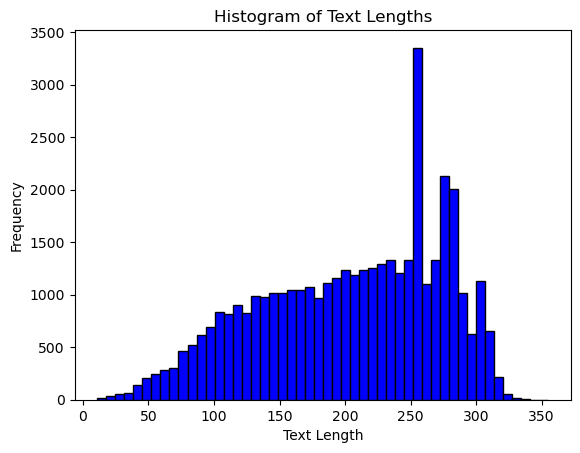

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

text_lengths = [len(text) for text in train_df['text']]
print(f'Max tweet size: {max(text_lengths)}')

# Plotting a histogram
plt.hist(text_lengths, bins=50, color='blue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')
plt.show()

The histogram above shows that nearly all of the training data is smaller than 350. Checking the max length shows that we can capture 100% of our training data by using 355 as our cutoff length. We decided to not exclude any rows and set the length limit at 355. We pad the input secquences to ensure that shorter tweets are the right size.

In [7]:
train_df['label'].value_counts()

label
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

As we can see, we do have class imbalance in this dataset. However, it is natural to have a lower number of people on the extreme ends (i.e., Extreme Positive and Extreme Negative) and more people near the middle (i.e., Positive, Neutral, and Negative). As such, we will apply stratification on the dataset to have this distribution in both the training and testing sets, since this is reflective of the real world.

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['label'])

In [9]:
print(y_train_encoded)


[3 4 4 ... 4 3 2]


In [10]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 355 # maximum and minimum number of words

# tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(train_df['text'])
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(train_df['text'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index), NUM_TOP_WORDS))
print('Train set:')
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index), top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y = keras.utils.to_categorical(y_train_encoded)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Train set:
Found 85198 unique tokens. Distilled to 85198 top words.
Shape of data tensor: (41157, 355)
Shape of label tensor: (41157, 5)
85198


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                          stratify=y_train_encoded, 
                                                          random_state=42)

In [13]:
train_size = X_train.shape[0]
test_size = X_test.shape[0]

print("Train size:", train_size)
print("Test size:", test_size)

Train size: 32925
Test size: 8232


The representation is now:

each word is converted to an integer
each tweet is a series of integers that represent the correct ordering of words
the target is one hot encoded

[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

We will use accuracy as the primary metric for evaluating our algorithm's performance. Because the model's purpose is to classify by sentiment, there is no significant or imbalanced consequence for incorrectly predicting a sentiment. Because of this, we will judge a model's usefulness by it's ability to correctly predict the sentiment of the highest proportion of tweets relative to alternative prediction models. Other attempts to classify this dataset on Kaggle have achieved a validation accuracy of 74%, so our goal will be to match this score with greater efficiency, or to outright beat their model's performance on the testing set.

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

To divide our data into training and testing, we will be using train test split from sklearn model selection. We will use an 80-20 train-test split which means that our training set contains 32925 data points and our testing set size is contains 8232 data points. The training and testing sizes are sufficient for our purposes of evaluating the effectiveness of our sentiment predictor model. We stratified the split to maintain the proportions of the response variable accross both the train and test set to reflect the actual proportions in our dataset. This method of train test splitting should yield a validation accuracy that mirrors how the model will perform when actually applying the model on unseen Tweets.

## Modeling ## 

[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

## Load GloVe embedding: ##

In [21]:
%%time
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('/Users/maxlink/Desktop/glove.6B.50d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (85199, 50) 
 Total words found: 30397 
 Percentage: 35.67764879869482
CPU times: user 1.93 s, sys: 55.7 ms, total: 1.98 s
Wall time: 1.99 s


In [22]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix], # here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

## Convolutional Architecture:
We will follow these steps:

use an embedding layer to translate to a dense representation of the entire sequence
train 1D filters to convolve with the output of the embedded sequence

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

NUM_CLASSES = 5

sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 355
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 355-4=351
x = MaxPooling1D(5)(x) # after max pool, 351/5 = 70
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 66
x = MaxPooling1D(5)(x) # after max pool, size is 66/5 = 13
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 9 elements long
x = MaxPooling1D(9)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 9 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 355)]             0         
                                                                 
 embedding (Embedding)       (None, 355, 50)           4259950   
                                                                 
 conv1d (Conv1D)             (None, 351, 128)          32128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 70, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 128)           82048     
                                                             

In [24]:
histories = []
tmp = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=2, batch_size=512)
histories.append(tmp)

Epoch 1/2


2024-04-25 13:35:29.945091: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 16s 242ms/step - loss: 1.5801 - acc: 0.2919 - val_loss: 1.4952 - val_acc: 0.3206
Epoch 2/2
65/65 [==============================] - 15s 231ms/step - loss: 1.4794 - acc: 0.3354 - val_loss: 1.4217 - val_acc: 0.3584


In [25]:
tmp = model.fit(X_train, y_train, 
                validation_data=(X_test, y_test),
                epochs=10, batch_size=512)
histories.append(tmp)

Epoch 1/10
65/65 [==============================] - 17s 257ms/step - loss: 1.4226 - acc: 0.3705 - val_loss: 1.4235 - val_acc: 0.3682
Epoch 2/10
65/65 [==============================] - 16s 241ms/step - loss: 1.3797 - acc: 0.3928 - val_loss: 1.3737 - val_acc: 0.3871
Epoch 3/10
65/65 [==============================] - 16s 243ms/step - loss: 1.3435 - acc: 0.4098 - val_loss: 1.3236 - val_acc: 0.4224
Epoch 4/10
65/65 [==============================] - 17s 258ms/step - loss: 1.3129 - acc: 0.4308 - val_loss: 1.2988 - val_acc: 0.4373
Epoch 5/10
65/65 [==============================] - 19s 295ms/step - loss: 1.2874 - acc: 0.4436 - val_loss: 1.2989 - val_acc: 0.4379
Epoch 6/10
65/65 [==============================] - 186s 3s/step - loss: 1.2595 - acc: 0.4566 - val_loss: 1.2638 - val_acc: 0.4589
Epoch 7/10
65/65 [==============================] - 15s 234ms/step - loss: 1.2391 - acc: 0.4672 - val_loss: 1.2588 - val_acc: 0.4586
Epoch 8/10
65/65 [==============================] - 15s 231ms/step - lo

In [26]:
tmp = model.fit(X_train, y_train, 
                validation_data=(X_test, y_test),
                epochs=10, batch_size=512)
histories.append(tmp)

Epoch 1/10
65/65 [==============================] - 16s 244ms/step - loss: 1.1732 - acc: 0.5008 - val_loss: 1.2952 - val_acc: 0.4431
Epoch 2/10
65/65 [==============================] - 16s 247ms/step - loss: 1.1579 - acc: 0.5088 - val_loss: 1.2453 - val_acc: 0.4668
Epoch 3/10
65/65 [==============================] - 16s 247ms/step - loss: 1.1397 - acc: 0.5178 - val_loss: 1.3239 - val_acc: 0.4365
Epoch 4/10
65/65 [==============================] - 17s 259ms/step - loss: 1.1255 - acc: 0.5247 - val_loss: 1.3039 - val_acc: 0.4399
Epoch 5/10
65/65 [==============================] - 17s 268ms/step - loss: 1.1211 - acc: 0.5253 - val_loss: 1.2628 - val_acc: 0.4546
Epoch 6/10
65/65 [==============================] - 17s 267ms/step - loss: 1.0959 - acc: 0.5373 - val_loss: 1.2760 - val_acc: 0.4611
Epoch 7/10
65/65 [==============================] - 17s 255ms/step - loss: 1.0897 - acc: 0.5406 - val_loss: 1.2905 - val_acc: 0.4481
Epoch 8/10
65/65 [==============================] - 17s 263ms/step - 

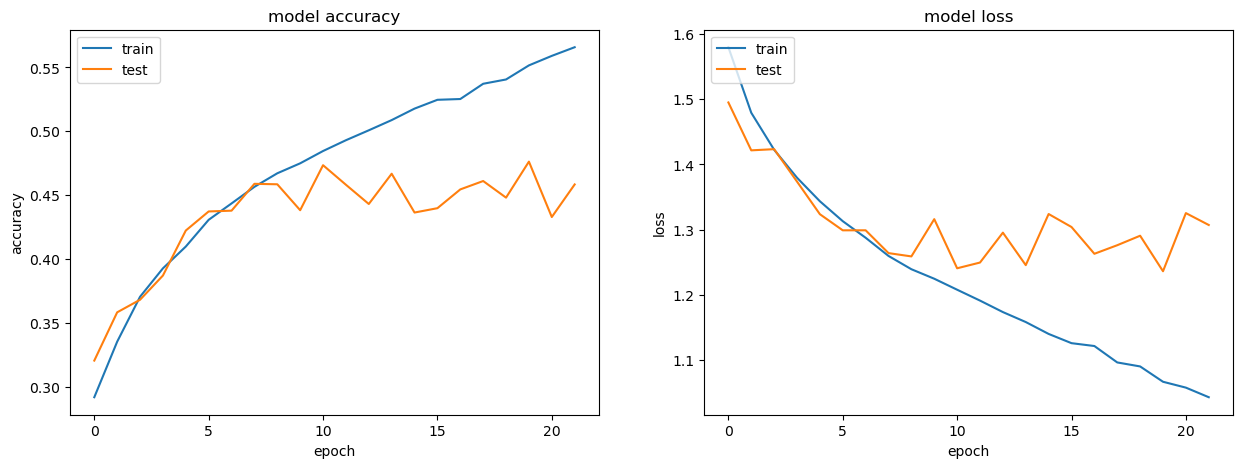

In [27]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score

# now lets see how well the model performed
yhat_proba = model.predict(X_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions 
yhat1 = np.round(yhat_proba.squeeze()) # round to get binary class

evals1 = accuracy_score(y_test, yhat1)
print("Accuracy:", evals1)

258/258 [==============================] - 2s 8ms/step
Accuracy: 0.29518950437317787


## Covolutional with AdaM as the optimizer:

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

NUM_CLASSES = 5

sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 355
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 355-4=351
x = MaxPooling1D(5)(x) # after max pool, 351/5 = 70
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 66
x = MaxPooling1D(5)(x) # after max pool, size is 66/5 = 13
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 9 elements long
x = MaxPooling1D(9)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 9 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model2 = Model(sequence_input, preds)

model2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

print(model2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 355)]             0         
                                                                 
 embedding (Embedding)       (None, 355, 50)           4259950   
                                                                 
 conv1d_3 (Conv1D)           (None, 351, 128)          32128     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 70, 128)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 70, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 66, 128)           82048     
                                                           

In [30]:
histories2 = []
tmp = model2.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=2, batch_size=512)
histories2.append(tmp)

Epoch 1/2
65/65 [==============================] - 18s 269ms/step - loss: 1.5690 - acc: 0.2883 - val_loss: 1.5059 - val_acc: 0.3196
Epoch 2/2
65/65 [==============================] - 17s 264ms/step - loss: 1.4701 - acc: 0.3412 - val_loss: 1.4154 - val_acc: 0.3785


In [31]:
tmp = model2.fit(X_train, y_train, 
                validation_data=(X_test, y_test),
                epochs=10, batch_size=512)
histories2.append(tmp)

Epoch 1/10
65/65 [==============================] - 17s 264ms/step - loss: 1.3915 - acc: 0.3873 - val_loss: 1.3544 - val_acc: 0.4079
Epoch 2/10
65/65 [==============================] - 17s 266ms/step - loss: 1.3451 - acc: 0.4101 - val_loss: 1.3169 - val_acc: 0.4312
Epoch 3/10
65/65 [==============================] - 18s 277ms/step - loss: 1.2995 - acc: 0.4354 - val_loss: 1.2985 - val_acc: 0.4391
Epoch 4/10
65/65 [==============================] - 17s 258ms/step - loss: 1.2707 - acc: 0.4528 - val_loss: 1.2680 - val_acc: 0.4558
Epoch 5/10
65/65 [==============================] - 17s 262ms/step - loss: 1.2417 - acc: 0.4671 - val_loss: 1.2670 - val_acc: 0.4523
Epoch 6/10
65/65 [==============================] - 18s 271ms/step - loss: 1.2143 - acc: 0.4808 - val_loss: 1.2382 - val_acc: 0.4713
Epoch 7/10
65/65 [==============================] - 17s 267ms/step - loss: 1.1929 - acc: 0.4922 - val_loss: 1.2370 - val_acc: 0.4702
Epoch 8/10
65/65 [==============================] - 18s 274ms/step - 

In [32]:
tmp = model2.fit(X_train, y_train, 
                validation_data=(X_test, y_test),
                epochs=10, batch_size=512)
histories2.append(tmp)

Epoch 1/10
65/65 [==============================] - 17s 261ms/step - loss: 1.1043 - acc: 0.5356 - val_loss: 1.2336 - val_acc: 0.4727
Epoch 2/10
65/65 [==============================] - 17s 262ms/step - loss: 1.0778 - acc: 0.5493 - val_loss: 1.2333 - val_acc: 0.4821
Epoch 3/10
65/65 [==============================] - 18s 278ms/step - loss: 1.0596 - acc: 0.5558 - val_loss: 1.2252 - val_acc: 0.4800
Epoch 4/10
65/65 [==============================] - 17s 260ms/step - loss: 1.0411 - acc: 0.5658 - val_loss: 1.2365 - val_acc: 0.4785
Epoch 5/10
65/65 [==============================] - 17s 268ms/step - loss: 1.0280 - acc: 0.5719 - val_loss: 1.2338 - val_acc: 0.4784
Epoch 6/10
65/65 [==============================] - 17s 269ms/step - loss: 1.0115 - acc: 0.5816 - val_loss: 1.2442 - val_acc: 0.4762
Epoch 7/10
65/65 [==============================] - 17s 264ms/step - loss: 0.9900 - acc: 0.5875 - val_loss: 1.2442 - val_acc: 0.4803
Epoch 8/10
65/65 [==============================] - 17s 264ms/step - 

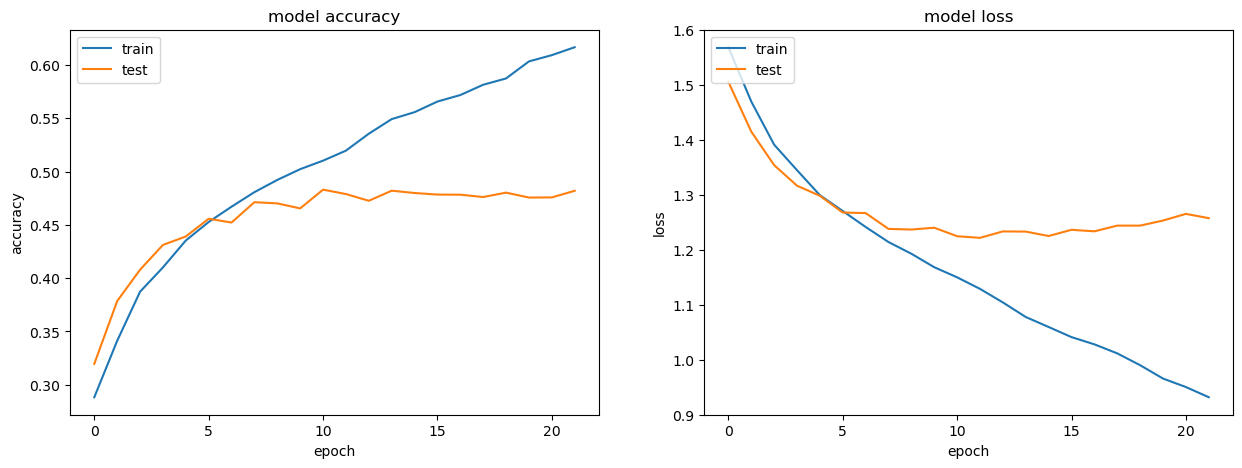

In [33]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories2])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
from sklearn.metrics import accuracy_score

# now lets see how well the model performed
yhat_proba = model2.predict(X_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions 
yhat2 = np.round(yhat_proba.squeeze()) # round to get binary class

evals2 = accuracy_score(y_test, yhat2)
print("Accuracy:", evals2)

258/258 [==============================] - 2s 8ms/step
Accuracy: 0.32325072886297374


## Transformer Architecture:

In [35]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [36]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
import tensorflow as tf

# first, let's replace the original embedding in the xformer
# with our custom GloVe embedding
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [37]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer = Model(inputs=inputs, outputs=preds)

model_xformer.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])

print(model_xformer.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 355)]             0         
                                                                 
 glove_token_and_position_em  (None, 355, 50)          4277700   
 bedding (GloveTokenAndPosit                                     
 ionEmbedding)                                                   
                                                                 
 transformer_block (Transfor  (None, 355, 50)          44132     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_8 (Dropout)         (None, 50)                0   

In [38]:
histories3 = []
tmp = model_xformer.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=2, batch_size=512)
histories3.append(tmp)

Epoch 1/2
65/65 [==============================] - 191s 3s/step - loss: 1.5166 - acc: 0.3095 - val_loss: 1.4329 - val_acc: 0.3488
Epoch 2/2
65/65 [==============================] - 190s 3s/step - loss: 1.4194 - acc: 0.3670 - val_loss: 1.3382 - val_acc: 0.4100


In [39]:
%%time 

tmp = model_xformer.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories3.append(tmp)

Epoch 1/10
65/65 [==============================] - 193s 3s/step - loss: 1.3446 - acc: 0.4027 - val_loss: 1.2809 - val_acc: 0.4368
Epoch 2/10
65/65 [==============================] - 200s 3s/step - loss: 1.2899 - acc: 0.4330 - val_loss: 1.2508 - val_acc: 0.4495
Epoch 3/10
65/65 [==============================] - 199s 3s/step - loss: 1.2569 - acc: 0.4528 - val_loss: 1.2313 - val_acc: 0.4642
Epoch 4/10
65/65 [==============================] - 193s 3s/step - loss: 1.2305 - acc: 0.4655 - val_loss: 1.3253 - val_acc: 0.4266
Epoch 5/10
65/65 [==============================] - 192s 3s/step - loss: 1.2109 - acc: 0.4761 - val_loss: 1.3265 - val_acc: 0.4289
Epoch 6/10
65/65 [==============================] - 194s 3s/step - loss: 1.1902 - acc: 0.4891 - val_loss: 1.1793 - val_acc: 0.4846
Epoch 7/10
65/65 [==============================] - 208s 3s/step - loss: 1.1710 - acc: 0.4991 - val_loss: 1.1594 - val_acc: 0.5010
Epoch 8/10
65/65 [==============================] - 212s 3s/step - loss: 1.1544 - a

In [40]:
%%time 

tmp = model_xformer.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories3.append(tmp)

Epoch 1/10
65/65 [==============================] - 201s 3s/step - loss: 1.1098 - acc: 0.5362 - val_loss: 1.1649 - val_acc: 0.5035
Epoch 2/10
65/65 [==============================] - 197s 3s/step - loss: 1.0975 - acc: 0.5407 - val_loss: 1.0837 - val_acc: 0.5412
Epoch 3/10
65/65 [==============================] - 201s 3s/step - loss: 1.0860 - acc: 0.5472 - val_loss: 1.0772 - val_acc: 0.5465
Epoch 4/10
65/65 [==============================] - 209s 3s/step - loss: 1.0765 - acc: 0.5539 - val_loss: 1.1152 - val_acc: 0.5264
Epoch 5/10
65/65 [==============================] - 207s 3s/step - loss: 1.0668 - acc: 0.5586 - val_loss: 1.1253 - val_acc: 0.5347
Epoch 6/10
65/65 [==============================] - 212s 3s/step - loss: 1.0616 - acc: 0.5588 - val_loss: 1.0575 - val_acc: 0.5647
Epoch 7/10
65/65 [==============================] - 210s 3s/step - loss: 1.0554 - acc: 0.5658 - val_loss: 1.0732 - val_acc: 0.5577
Epoch 8/10
65/65 [==============================] - 205s 3s/step - loss: 1.0476 - a

In [43]:
%%time 

tmp = model_xformer.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=5, batch_size=512)
histories3.append(tmp)

Epoch 1/5
65/65 [==============================] - 184s 3s/step - loss: 1.0367 - acc: 0.5737 - val_loss: 1.0787 - val_acc: 0.5469
Epoch 2/5
65/65 [==============================] - 184s 3s/step - loss: 1.0359 - acc: 0.5756 - val_loss: 1.0918 - val_acc: 0.5456
Epoch 3/5
65/65 [==============================] - 190s 3s/step - loss: 1.0293 - acc: 0.5769 - val_loss: 1.0721 - val_acc: 0.5556
Epoch 4/5
65/65 [==============================] - 186s 3s/step - loss: 1.0255 - acc: 0.5785 - val_loss: 1.0541 - val_acc: 0.5643
Epoch 5/5
65/65 [==============================] - 196s 3s/step - loss: 1.0230 - acc: 0.5816 - val_loss: 1.1446 - val_acc: 0.5306
CPU times: user 1h 3min 54s, sys: 15min 56s, total: 1h 19min 50s
Wall time: 15min 39s


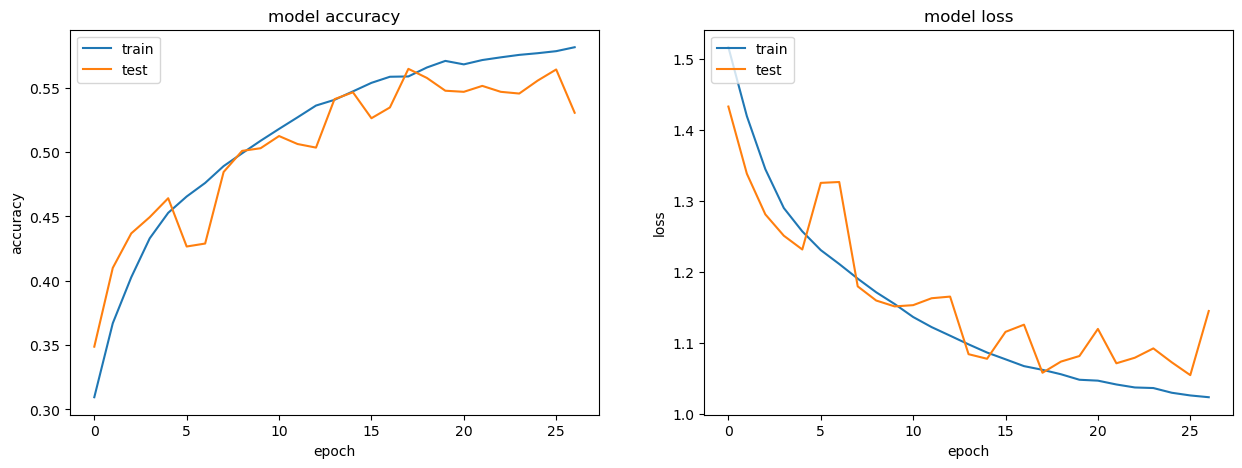

In [44]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories3])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
from sklearn.metrics import accuracy_score

# now lets see how well the model performed
yhat_proba = model_xformer.predict(X_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions 
yhat3 = np.round(yhat_proba.squeeze()) # round to get binary class

evals3 = accuracy_score(y_test, yhat3)
print("Accuracy:", evals3)

258/258 [==============================] - 17s 66ms/step
Accuracy: 0.40816326530612246


## Transformer with AdaM as the optimizer:

In [46]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer2 = Model(inputs=inputs, outputs=preds)

model_xformer2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

print(model_xformer2.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 355)]             0         
                                                                 
 glove_token_and_position_em  (None, 355, 50)          4277700   
 bedding_1 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_1 (Transf  (None, 355, 50)          44132     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_12 (Dropout)        (None, 50)                0   

In [47]:
histories4 = []
tmp = model_xformer2.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=2, batch_size=512)
histories4.append(tmp)

Epoch 1/2
65/65 [==============================] - 184s 3s/step - loss: 1.4780 - acc: 0.3295 - val_loss: 1.3599 - val_acc: 0.3908
Epoch 2/2
65/65 [==============================] - 183s 3s/step - loss: 1.3275 - acc: 0.4135 - val_loss: 1.2722 - val_acc: 0.4378


In [48]:
%%time

tmp = model_xformer2.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories4.append(tmp)

Epoch 1/10
65/65 [==============================] - 197s 3s/step - loss: 1.2518 - acc: 0.4543 - val_loss: 1.2110 - val_acc: 0.4700
Epoch 2/10
65/65 [==============================] - 184s 3s/step - loss: 1.2240 - acc: 0.4705 - val_loss: 1.1971 - val_acc: 0.4836
Epoch 3/10
65/65 [==============================] - 182s 3s/step - loss: 1.2007 - acc: 0.4833 - val_loss: 1.1837 - val_acc: 0.4889
Epoch 4/10
65/65 [==============================] - 183s 3s/step - loss: 1.1733 - acc: 0.4986 - val_loss: 1.1611 - val_acc: 0.4971
Epoch 5/10
65/65 [==============================] - 182s 3s/step - loss: 1.1548 - acc: 0.5052 - val_loss: 1.1479 - val_acc: 0.5128
Epoch 6/10
65/65 [==============================] - 183s 3s/step - loss: 1.1391 - acc: 0.5168 - val_loss: 1.1349 - val_acc: 0.5190
Epoch 7/10
65/65 [==============================] - 184s 3s/step - loss: 1.1217 - acc: 0.5240 - val_loss: 1.1213 - val_acc: 0.5254
Epoch 8/10
65/65 [==============================] - 184s 3s/step - loss: 1.1066 - a

In [49]:
%%time

tmp = model_xformer2.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories4.append(tmp)

Epoch 1/10
65/65 [==============================] - 186s 3s/step - loss: 1.0703 - acc: 0.5568 - val_loss: 1.0828 - val_acc: 0.5555
Epoch 2/10
65/65 [==============================] - 185s 3s/step - loss: 1.0618 - acc: 0.5612 - val_loss: 1.0702 - val_acc: 0.5572
Epoch 3/10
65/65 [==============================] - 186s 3s/step - loss: 1.0572 - acc: 0.5628 - val_loss: 1.0841 - val_acc: 0.5610
Epoch 4/10
65/65 [==============================] - 187s 3s/step - loss: 1.0528 - acc: 0.5628 - val_loss: 1.0717 - val_acc: 0.5637
Epoch 5/10
65/65 [==============================] - 187s 3s/step - loss: 1.0462 - acc: 0.5694 - val_loss: 1.0731 - val_acc: 0.5630
Epoch 6/10
65/65 [==============================] - 186s 3s/step - loss: 1.0396 - acc: 0.5728 - val_loss: 1.0592 - val_acc: 0.5655
Epoch 7/10
65/65 [==============================] - 186s 3s/step - loss: 1.0331 - acc: 0.5754 - val_loss: 1.0739 - val_acc: 0.5639
Epoch 8/10
65/65 [==============================] - 186s 3s/step - loss: 1.0345 - a

In [50]:
%%time

tmp = model_xformer2.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=5, batch_size=512)
histories4.append(tmp)

Epoch 1/5
65/65 [==============================] - 190s 3s/step - loss: 1.0238 - acc: 0.5814 - val_loss: 1.0656 - val_acc: 0.5637
Epoch 2/5
65/65 [==============================] - 190s 3s/step - loss: 1.0210 - acc: 0.5819 - val_loss: 1.0580 - val_acc: 0.5701
Epoch 3/5
65/65 [==============================] - 188s 3s/step - loss: 1.0174 - acc: 0.5848 - val_loss: 1.0579 - val_acc: 0.5705
Epoch 4/5
65/65 [==============================] - 188s 3s/step - loss: 1.0162 - acc: 0.5810 - val_loss: 1.0582 - val_acc: 0.5750
Epoch 5/5
65/65 [==============================] - 189s 3s/step - loss: 1.0136 - acc: 0.5845 - val_loss: 1.0581 - val_acc: 0.5626
CPU times: user 1h 6min 33s, sys: 17min 3s, total: 1h 23min 36s
Wall time: 15min 46s


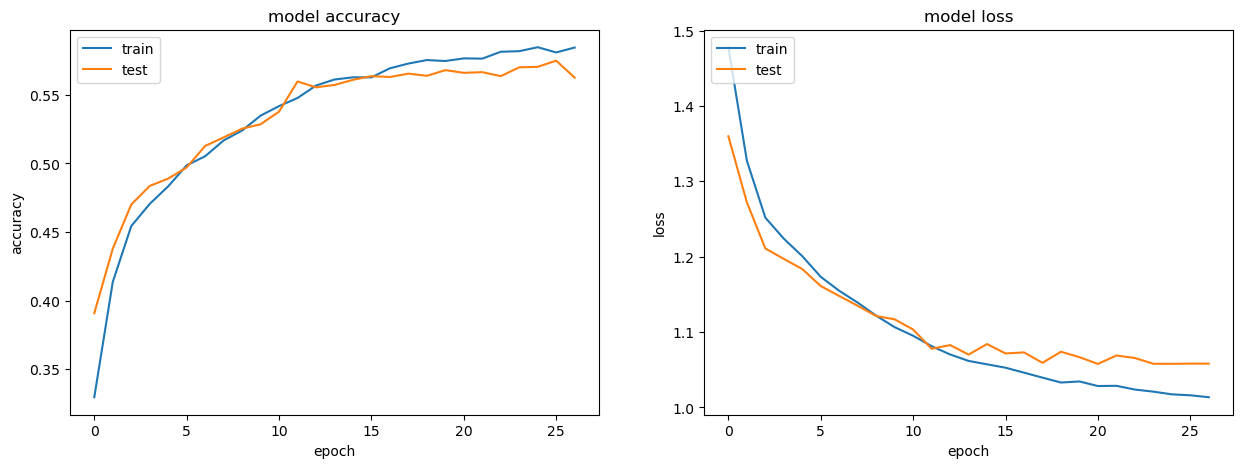

In [51]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories4])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
from sklearn.metrics import accuracy_score

# now lets see how well the model performed
yhat_proba = model_xformer2.predict(X_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions 
yhat4 = np.round(yhat_proba.squeeze()) # round to get binary class

evals4 = accuracy_score(y_test, yhat4)
print("Accuracy:", evals4)

258/258 [==============================] - 17s 65ms/step
Accuracy: 0.4268707482993197


[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer. Visualize the performance of training and validation sets versus the training iterations, showing that the model converged.

## Add Second Multi-headed Self Attention Layer:

In [53]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer2 = Model(inputs=inputs, outputs=preds)

model_xformer2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

print(model_xformer2.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 355)]             0         
                                                                 
 glove_token_and_position_em  (None, 355, 50)          4277700   
 bedding_2 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_2 (Transf  (None, 355, 50)          44132     
 ormerBlock)                                                     
                                                                 
 transformer_block_3 (Transf  (None, 355, 50)          44132     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_2   (None, 50)               0   

In [54]:
histories5 = []
tmp = model_xformer2.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=2, batch_size=512)
histories5.append(tmp)

Epoch 1/2
65/65 [==============================] - 380s 6s/step - loss: 1.4811 - acc: 0.3287 - val_loss: 1.4097 - val_acc: 0.3712
Epoch 2/2
65/65 [==============================] - 380s 6s/step - loss: 1.3455 - acc: 0.4035 - val_loss: 1.2527 - val_acc: 0.4474


In [55]:
%%time

tmp = model_xformer2.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories5.append(tmp)

Epoch 1/10
65/65 [==============================] - 381s 6s/step - loss: 1.2564 - acc: 0.4506 - val_loss: 1.2278 - val_acc: 0.4661
Epoch 2/10
65/65 [==============================] - 379s 6s/step - loss: 1.2285 - acc: 0.4654 - val_loss: 1.2378 - val_acc: 0.4733
Epoch 3/10
65/65 [==============================] - 382s 6s/step - loss: 1.2021 - acc: 0.4795 - val_loss: 1.2007 - val_acc: 0.4955
Epoch 4/10
65/65 [==============================] - 400s 6s/step - loss: 1.1731 - acc: 0.4980 - val_loss: 1.1756 - val_acc: 0.4982
Epoch 5/10
65/65 [==============================] - 409s 6s/step - loss: 1.1381 - acc: 0.5191 - val_loss: 1.1221 - val_acc: 0.5310
Epoch 6/10
65/65 [==============================] - 413s 6s/step - loss: 1.1044 - acc: 0.5381 - val_loss: 1.1026 - val_acc: 0.5509
Epoch 7/10
65/65 [==============================] - 388s 6s/step - loss: 1.0841 - acc: 0.5469 - val_loss: 1.1009 - val_acc: 0.5525
Epoch 8/10
65/65 [==============================] - 382s 6s/step - loss: 1.0649 - a

In [56]:
%%time

tmp = model_xformer2.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories5.append(tmp)

Epoch 1/10
65/65 [==============================] - 404s 6s/step - loss: 1.0347 - acc: 0.5759 - val_loss: 1.1039 - val_acc: 0.5599
Epoch 2/10
65/65 [==============================] - 391s 6s/step - loss: 1.0313 - acc: 0.5799 - val_loss: 1.0670 - val_acc: 0.5728
Epoch 3/10
65/65 [==============================] - 388s 6s/step - loss: 1.0155 - acc: 0.5862 - val_loss: 1.0640 - val_acc: 0.5839
Epoch 4/10
65/65 [==============================] - 390s 6s/step - loss: 1.0194 - acc: 0.5835 - val_loss: 1.0624 - val_acc: 0.5888
Epoch 5/10
65/65 [==============================] - 380s 6s/step - loss: 1.0101 - acc: 0.5892 - val_loss: 1.0647 - val_acc: 0.5853
Epoch 6/10
65/65 [==============================] - 387s 6s/step - loss: 1.0045 - acc: 0.5897 - val_loss: 1.0647 - val_acc: 0.5793
Epoch 7/10
65/65 [==============================] - 387s 6s/step - loss: 0.9987 - acc: 0.5938 - val_loss: 1.0689 - val_acc: 0.5920
Epoch 8/10
65/65 [==============================] - 395s 6s/step - loss: 0.9862 - a

In [57]:
%%time

tmp = model_xformer2.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=5, batch_size=512)
histories5.append(tmp)

Epoch 1/5
65/65 [==============================] - 379s 6s/step - loss: 0.9771 - acc: 0.6054 - val_loss: 1.0910 - val_acc: 0.5977
Epoch 2/5
65/65 [==============================] - 383s 6s/step - loss: 0.9687 - acc: 0.6097 - val_loss: 1.0994 - val_acc: 0.5969
Epoch 3/5
65/65 [==============================] - 384s 6s/step - loss: 0.9655 - acc: 0.6114 - val_loss: 1.0948 - val_acc: 0.5965
Epoch 4/5
65/65 [==============================] - 382s 6s/step - loss: 0.9594 - acc: 0.6128 - val_loss: 1.0571 - val_acc: 0.5988
Epoch 5/5
65/65 [==============================] - 371s 6s/step - loss: 0.9540 - acc: 0.6162 - val_loss: 1.0896 - val_acc: 0.5971
CPU times: user 2h 12min 4s, sys: 32min 54s, total: 2h 44min 59s
Wall time: 31min 38s


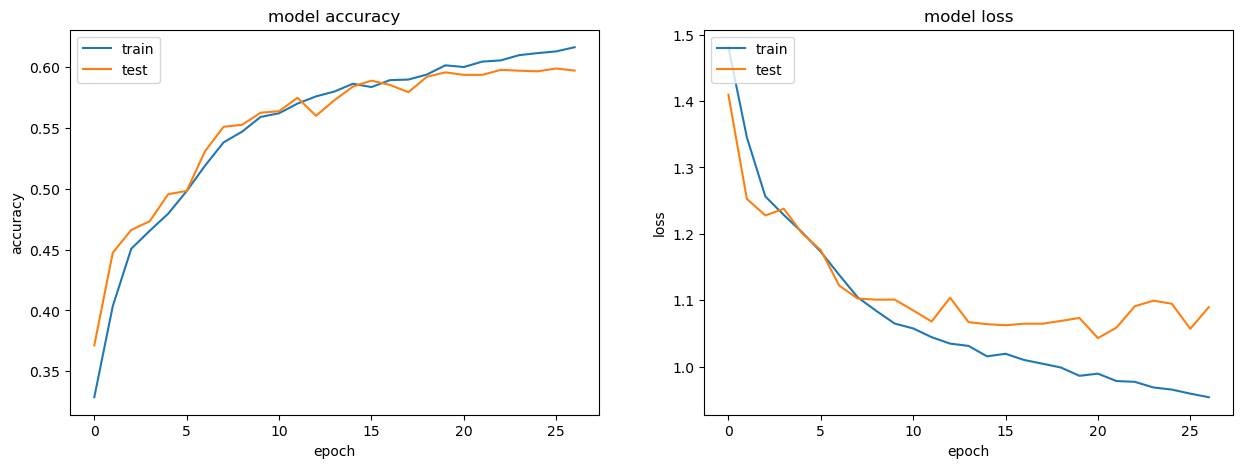

In [58]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories5])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
from sklearn.metrics import accuracy_score

# now lets see how well the model performed
yhat_proba = model_xformer2.predict(X_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions 
yhat5 = np.round(yhat_proba.squeeze()) # round to get binary class

evals5 = accuracy_score(y_test, yhat5)
print("Accuracy:", evals5)

258/258 [==============================] - 33s 127ms/step
Accuracy: 0.5513848396501457


[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained. Use proper statistical comparison techniques to determine which method(s) is (are) superior.

In [60]:
#===================================================

print('Mean accuracy for Model 1, Convolutional with RMSProp:', evals1)
print('Mean accuracy for Model 2, Convolutional with AdaM:', evals2)
print('Mean accuracy for Model 3, Transformer with RMSProp:', evals3)
print('Mean accuracy for Model 4, Transformer with AdaM:', evals4)
print('Mean accuracy for Model 5, Transformer with Second Multi-headed Self Attention:', evals5)

#===================================================

Mean accuracy for Model 1, Convolutional with RMSProp: 0.29518950437317787
Mean accuracy for Model 2, Convolutional with AdaM: 0.32325072886297374
Mean accuracy for Model 3, Transformer with RMSProp: 0.40816326530612246
Mean accuracy for Model 4, Transformer with AdaM: 0.4268707482993197
Mean accuracy for Model 5, Transformer with Second Multi-headed Self Attention: 0.5513848396501457


To statistically compare the performance of the models, we captured their accuracy on the testing set after running each model until convergence (usually around 20-30 epochs). The model with the highest average accuracy is considered the best as it will be the most useful as a sentiment classifier. A comparison accross the five models shows that the model with Transformer architecture plus Second Multi-headed Self Attention performs the best with an accuracy of 55%, closely followed by the Transformer model with AdaM at an accuracy of 42%. Unsurprisingly, using AdaM instead of RMSProp will boost performance anywhere from 2% to a little over 13%. Lastly, all three of the Transformer models performed better, even if its just slightly, than their CNN counterparts. The clear winner and obvious recommendation is our model 5: Transformer with Second Multi-headed Self Attention (and AdaM).

## Exceptional Work
One idea (required for 7000 level students to do one of these options): Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application?

## Convolutional with Variance Pooling:

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Subtract
from tensorflow.keras.layers import Concatenate

EMBED_SIZE = 50  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 355
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 355-4=351
x = MaxPooling1D(5)(x)# after max pool, 351/5 = 70
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 66
x = MaxPooling1D(5)(x) # after max pool, size is 66/5 = 13
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])


x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xvec = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_xvec.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

print(model_xvec.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 355)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 355, 50)      4259950     ['input_6[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 351, 128)     32128       ['embedding[2][0]']              
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 70, 128)     0           ['conv1d_6[0][0]']               
                                                                                            

In [62]:
histories6 = []
tmp = model_xvec.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=2, batch_size=512)
histories6.append(tmp)

Epoch 1/2
65/65 [==============================] - 18s 266ms/step - loss: 1.5279 - acc: 0.3047 - val_loss: 1.4659 - val_acc: 0.3401
Epoch 2/2
65/65 [==============================] - 17s 264ms/step - loss: 1.4130 - acc: 0.3744 - val_loss: 1.3701 - val_acc: 0.3922


In [63]:
tmp = model_xvec.fit(X_train, y_train, 
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories6.append(tmp)

Epoch 1/10
65/65 [==============================] - 17s 265ms/step - loss: 1.3364 - acc: 0.4166 - val_loss: 1.3119 - val_acc: 0.4252
Epoch 2/10
65/65 [==============================] - 17s 266ms/step - loss: 1.2981 - acc: 0.4366 - val_loss: 1.2824 - val_acc: 0.4440
Epoch 3/10
65/65 [==============================] - 17s 266ms/step - loss: 1.2560 - acc: 0.4597 - val_loss: 1.2669 - val_acc: 0.4520
Epoch 4/10
65/65 [==============================] - 17s 265ms/step - loss: 1.2288 - acc: 0.4730 - val_loss: 1.2488 - val_acc: 0.4649
Epoch 5/10
65/65 [==============================] - 17s 266ms/step - loss: 1.2019 - acc: 0.4868 - val_loss: 1.2629 - val_acc: 0.4476
Epoch 6/10
65/65 [==============================] - 17s 265ms/step - loss: 1.1787 - acc: 0.4973 - val_loss: 1.2327 - val_acc: 0.4695
Epoch 7/10
65/65 [==============================] - 17s 264ms/step - loss: 1.1514 - acc: 0.5119 - val_loss: 1.2202 - val_acc: 0.4753
Epoch 8/10
65/65 [==============================] - 17s 265ms/step - 

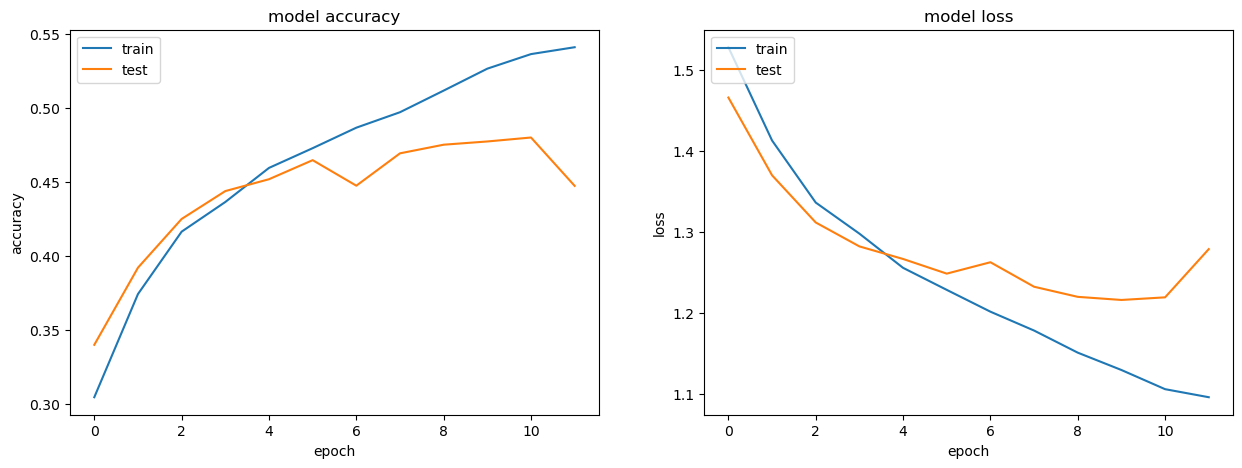

In [64]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories6])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
from sklearn.metrics import accuracy_score

# now lets see how well the model performed
yhat_proba = model_xvec.predict(X_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions 
yhat6 = np.round(yhat_proba.squeeze()) # round to get binary class

evals6 = accuracy_score(y_test, yhat6)
print("Accuracy:", evals6)

258/258 [==============================] - 2s 8ms/step
Accuracy: 0.22351797862001943


In [66]:
#===================================================

print('Mean accuracy for Model 6, Convolutional with Variance Pooling:', evals6)
print('Mean accuracy for Model 2, Convolutional with AdaM:', evals2)

#===================================================

Mean accuracy for Model 6, Convolutional with Variance Pooling: 0.22351797862001943
Mean accuracy for Model 2, Convolutional with AdaM: 0.32325072886297374


For our exceptional work, we wanted to revisit our CNN models and give them another chance. Both of our CNN models performed worse than our three Transformer models, so we were curious to see if we could change that. For this third CNN model, we kept AdaM (since it was the better performing CNN model out of the two) and added variance pooling to it. While this new model trained much more quickly, it unfortunately had a worse performance than our previous best CNN model. Alas, our efforts were in vain...